# Initial imports

In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        path_dataset = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sys
import sys, warnings
warnings.filterwarnings('ignore')

# Understanding the dataset

In [3]:
def split_numerical_categorical_cols(df):
    """
    Simple function to get numerical and categorical cols of a dataframe splitted.

    Parameters:
    - df: The dataframe to analyze.

    Return:
    - Numerical_cols: Only the numerical cols of the initial dataframe.
    - Categorical_cols: Only the categorical cols of the initial dataframe.
    """

    numerical_cols = [colname for colname in df.columns if df[colname].dtype in ['int64', 'float64']]
    categorical_cols = [colname for colname in df.columns if df[colname].dtype in ['object']]
    return numerical_cols, categorical_cols

In [4]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
numerical_cols, categorical_cols = split_numerical_categorical_cols(df)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
def detect_and_delete_duplicated(df, only_info=False):
    """
    Simple function to show and delete duplicate entries in a DataFrame

    Parameters:
    - df: The DataFrame to erase duplicate entries.
    - only_info: If you only want to know how many duplicates are.

    Return:
    - df: The DataFrame cleaned.
    """
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    return df.drop_duplicates() if not only_info else None

In [6]:
df = detect_and_delete_duplicated(df)
df.info()

Number of duplicate rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14

In [7]:
def detect_outliers(df, column, quant=0.25, add=1.5):
    """
    Function to find outlayers in a select column, with a modifiable quantile and addition.

    Parameters:
    - df: The DataFrame to analyze.
    - column: Column name to analyze.
    - quant (opt): set quantile.
    - add (opt): set addition to the superior and inferior limits calculation.

    Return:
    - Text indicating how many outlayers, in which column and their indexes.
    """

    # Calculate both quantiles, IQR
    Q3 = df[column].quantile(1-quant)
    Q1 = df[column].quantile(0+quant)
    IQR = Q3 - Q1

    # Calculate superior and inferior limits
    superior = Q3 + (add * IQR)
    inferior = Q1 - (add * IQR)
    out_sup = df[df[column] > superior].index
    out_inf = df[df[column] < inferior].index

    # Get outlayers and return the information
    outliers = list(set(out_sup).union(set(out_inf)))
    return (f'There are {len(outliers)} outlayers in the column {column} with the next indexs: {outliers}')
    

def get_columns_info(df, get_outliers=False):
    """
    Function to show initial information about the columns in the dataframe.
    You will get the shape, total nulls and total nulls per column,
    and a summary of numerical and categorical vars separately.

    Parameters:
    - df: The dataframe to analyze.
    """

    # Show initial and basic information
    print('Shape -> ', df.shape)
    print('Null values (number) per column -> ', df.isnull().sum())

    # Get numerical and categorical columns, and create two separate dataframes
    numerical_cols, categorical_cols = split_numerical_categorical_cols(df)

    numerical_df = df[numerical_cols]
    numerical_summary = pd.DataFrame({
        'DataType': numerical_df.dtypes,
        'Min': numerical_df.min(),
        'Max': numerical_df.max(),
    })

    categorical_df = df[categorical_cols]
    categorical_summary = pd.DataFrame({
        'DataType': categorical_df.dtypes,
        'Unique': categorical_df.apply(lambda col: ', '.join(map(str, col.unique())))
    })

    # Print the information and returns
    print("\nNumerical Summary:", numerical_summary)
    print("\nCategorical Summary:", categorical_summary)
    
    if get_outliers:
        print("\nOutliers:\n")
        for col in numerical_cols: print(detect_outliers(df, col))

In [8]:
get_columns_info(df)

Shape ->  (569, 33)
Null values (number) per column ->  id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst

In [9]:
def plot_binary_distribution(target):
    unique, counts_uniques = np.unique(target, return_counts=True)
    print(f"Number of class 0 samples (Benign): {counts_uniques[0]}")
    print(f"Number of class 1 samples (Malign): {counts_uniques[1]}")

    plt.bar(unique, counts_uniques)
    plt.title("Distribution of tumor type")
    plt.xticks([0, 1])
    plt.xlabel("Tumor type (0 benign - 1 malign)")
    plt.ylabel("Quantity")
    plt.show()

    return counts_uniques

Number of class 0 samples (Benign): 357
Number of class 1 samples (Malign): 212


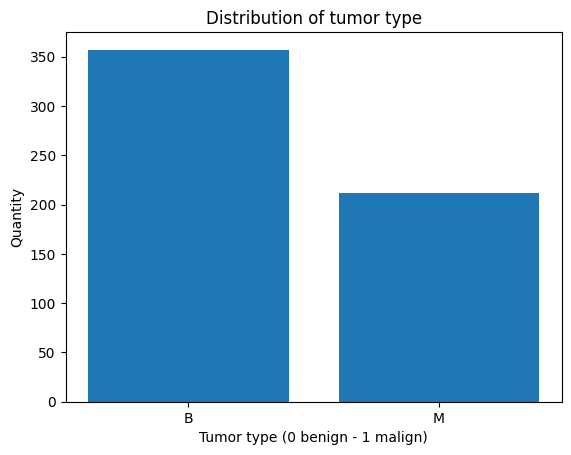

array([357, 212])

In [10]:
plot_binary_distribution(df['diagnosis'])

## Initial context, observations and information



Initial columns and a brief description:

1) ID number
2) Diagnosis
   
- After that, ten real-valued features are computed for each cell nucleus:
   
3) Radius (mean of distances from center to points on the perimeter)
4) Texture (standard deviation of gray-scale values)
5) Perimeter
6) Area
7) Smoothness (local variation in radius lengths)
8) Compactness (perimeter^2 / area - 1.0)
9) Concavity (severity of concave portions of the contour)
10) Concave points (number of concave portions of the contour)
11) Symmetry
12) Fractal dimension ("coastline approximation" - 1)

- After that, mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

Initial observations:
- The dataset has 569 rows and 33 columns related to medical measurements, and the target variable (diagnosis) represents whether a tumor is (M)align or (B)ening.
- Already checked the null values. Apart from the full-null column 'Unnamed: 32' that will be dropped, there are no more missing values in the dataset.
- ID column is irrelevant and will be dropped too.
- Target variable needs to be encoded (diagnosis 'M' to 0 and 'B' to 1).
- The distribution of the target variables shows that there are more entries for bening tumors than malign.

In [11]:
df.drop('id', axis=1, inplace=True)
df.drop('Unnamed: 32', axis=1, inplace=True)

df['diagnosis'] = df['diagnosis'].replace(to_replace='M', value = 1)
df['diagnosis'] = df['diagnosis'].replace(to_replace='B', value = 0)

y = df.diagnosis.values
x_data = df.drop(['diagnosis'], axis=1)

# Exploratory Data Analysis

In [12]:
df_eda = df.copy()
df_eda.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Deleting irrelevant columns

<Axes: >

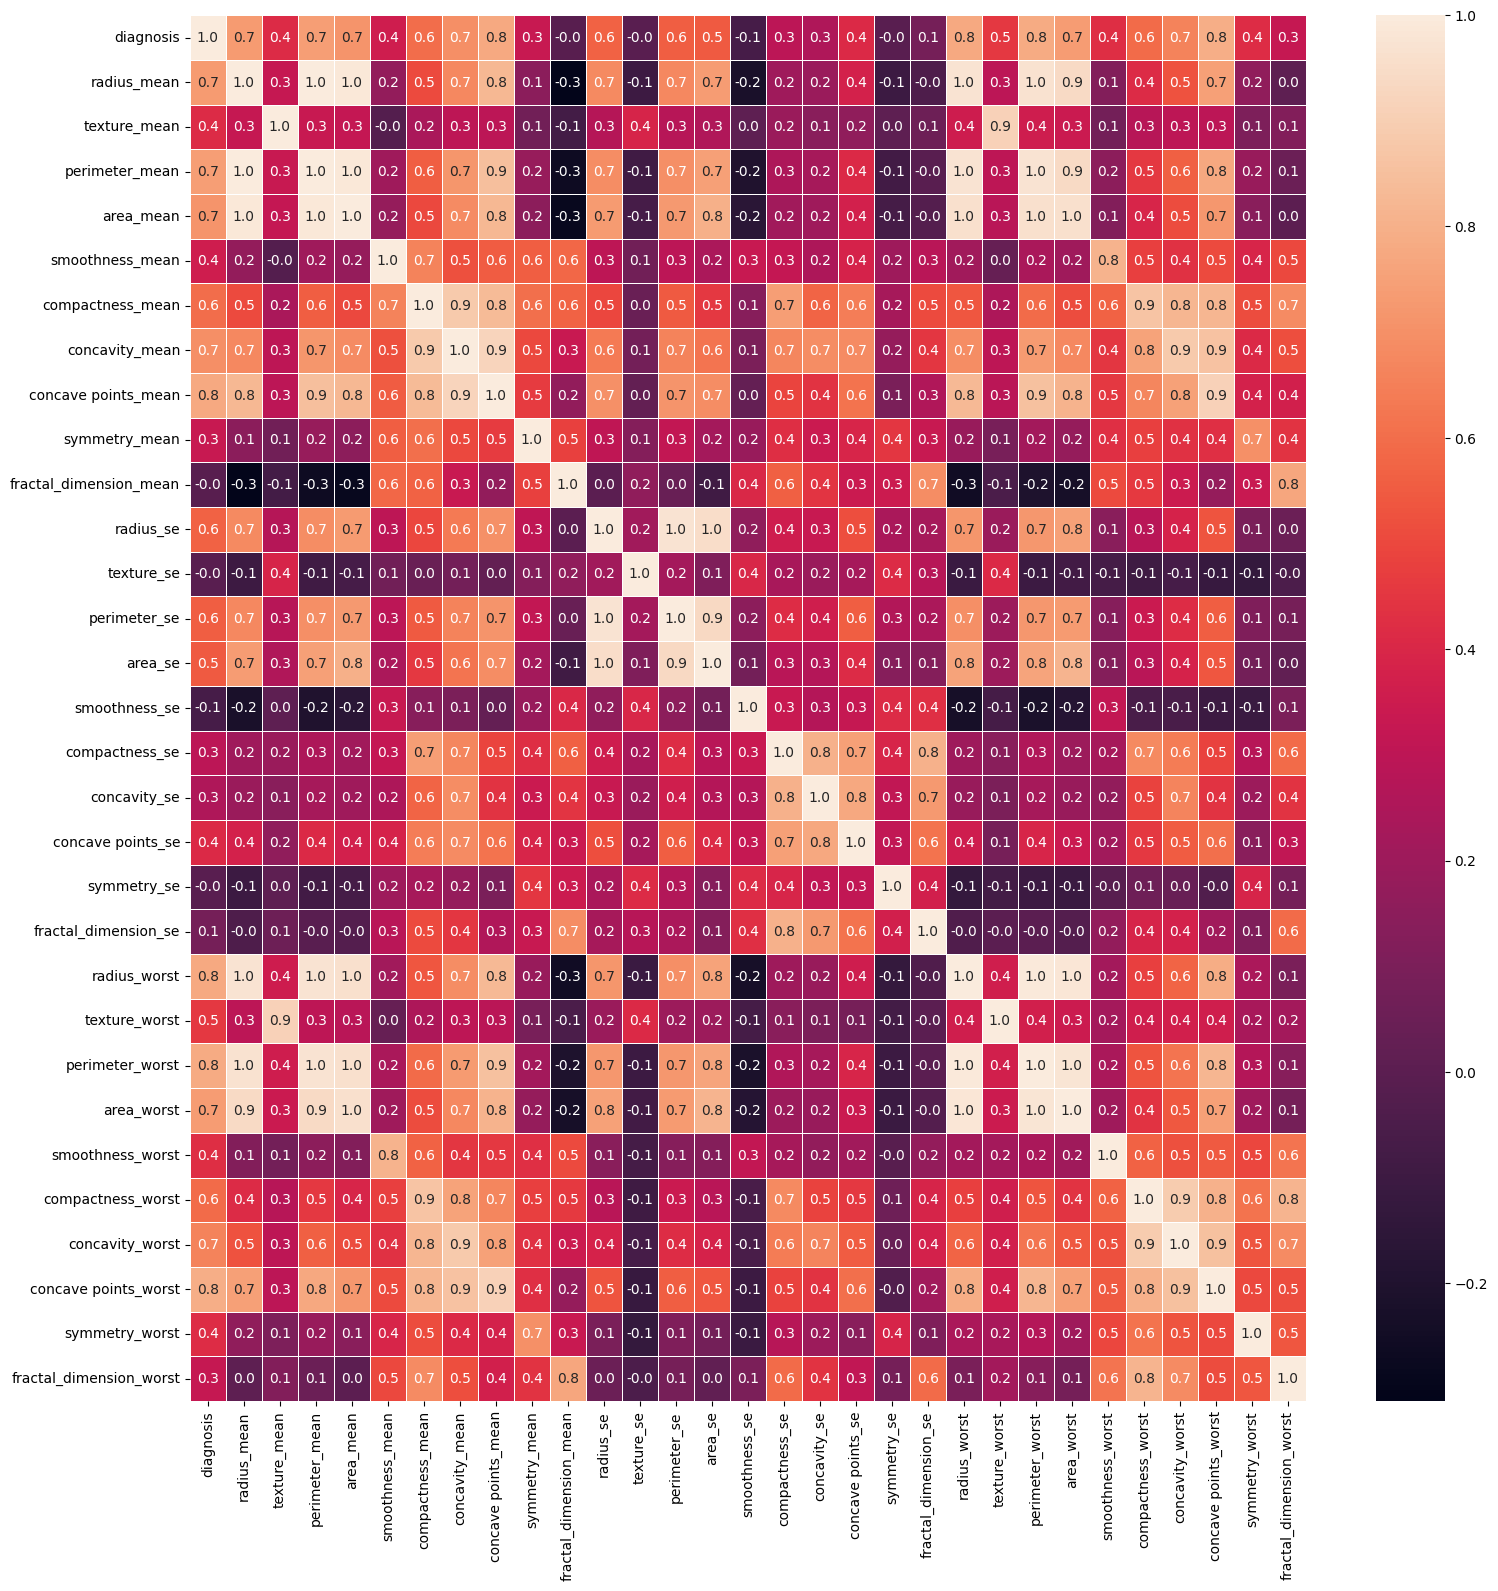

In [13]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_eda.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

smoothness_se             -0.067016
fractal_dimension_mean    -0.012838
texture_se                -0.008303
symmetry_se               -0.006522
fractal_dimension_se       0.077972
concavity_se               0.253730
compactness_se             0.292999
fractal_dimension_worst    0.323872
symmetry_mean              0.330499
smoothness_mean            0.358560
concave points_se          0.408042
texture_mean               0.415185
symmetry_worst             0.416294
smoothness_worst           0.421465
texture_worst              0.456903
area_se                    0.548236
perimeter_se               0.556141
radius_se                  0.567134
compactness_worst          0.590998
compactness_mean           0.596534
concavity_worst            0.659610
concavity_mean             0.696360
area_mean                  0.708984
radius_mean                0.730029
area_worst                 0.733825
perimeter_mean             0.742636
radius_worst               0.776454
concave points_mean        0

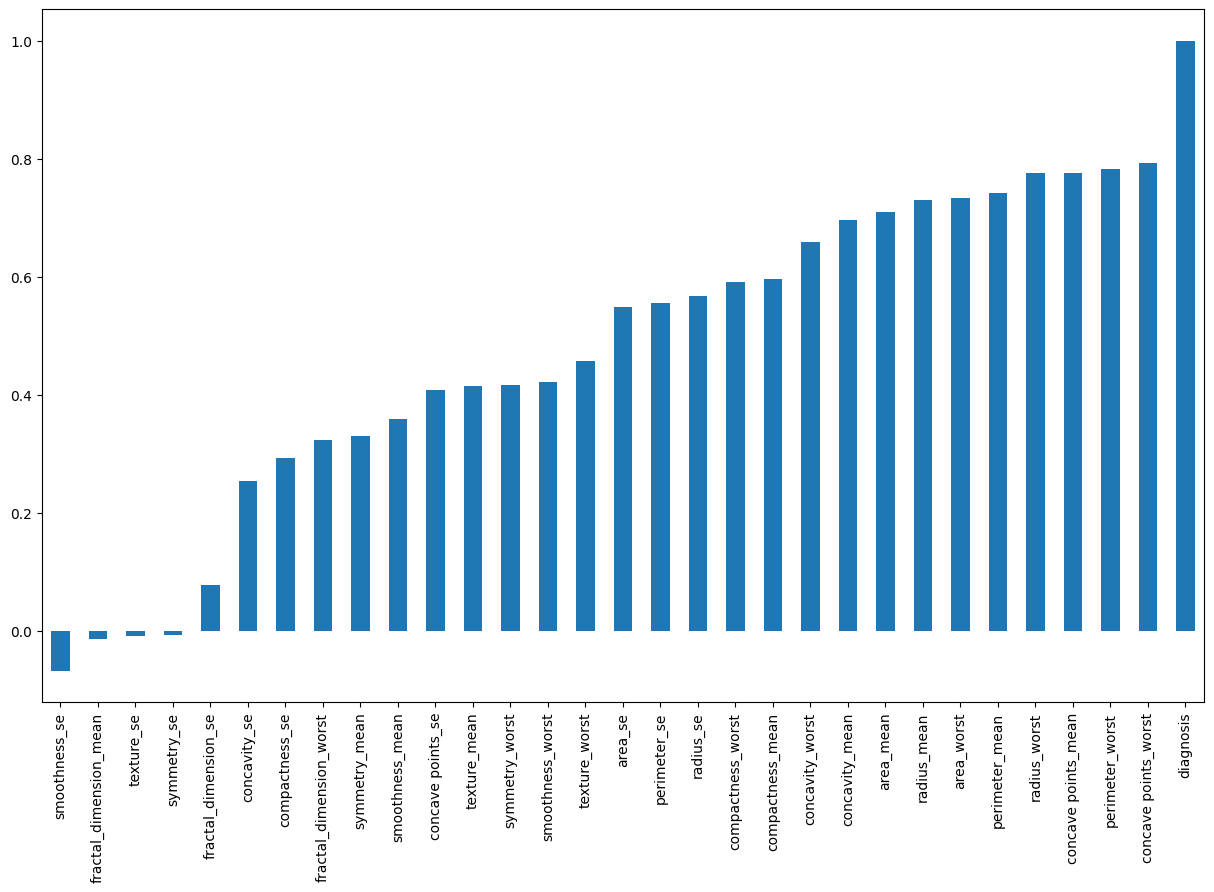

In [14]:
fig = plt.figure(figsize=(15,9))
df_eda.corr()['diagnosis'].sort_values(ascending=True).plot(kind='bar')
print(df_eda.corr()['diagnosis'].sort_values(ascending=True))
plt.show()

First of all, it is important to remove columns that not offer new or enough information. For this, I will take into account both columns most correlated with the target variable and the correlation between each variable. 

Columns with the low correlation between the target variable (less than 0.2) will be deleted: *smoothness_se, fractal_dimension_mean, texture_se, symmetry_se*.

The most correlated column with the target variable is **concave points_worst**.
- Concepts of concave points, concavity and compactness seems to be extremely correlated.
- In terms of worst, both concavity and compactness are highly correlated and will be deleted.
- In terms of mean, all of them are also highly correlated and will be deleted.
- In terms of standrad error, I will only maintain **concave points_se** because is the most correlated with the target variable and also has high correlation with the others standard error values.

The second most correlated with the target variable is **perimeter_worst**.
- Concepts of radius, perimeter and area means are extremely correlated.
- Perimeter_worst has extremely correlation with the other two worst (radius and area) and with all means, and I will remove all of them.
- Regarding standard error all of them will be also deleted because of their highly correlation with perimeter_worst.

The third most correlated with the target variable is **texture_worst**.

- Based on this column, I'll delete *texture_mean* due to the correlation.

The fourth most correlated with the target variable is **smoothness_worst**.

- Based on this column, I'll delete *smoothness_mean* due to the correlation.

The fifth most correlated with the target variable is **symmetry_worst**.

- Based on this column, I'll delete *symmetry_mean* due to the correlation.

Let's apply these changes.

In [15]:
temp_data = df_eda.corr()['diagnosis'].sort_values(ascending=True)
temp_df = temp_data[temp_data < 0.3].index.tolist()
print(temp_df)
df_eda.drop(temp_df, axis=1, inplace=True)

['smoothness_se', 'fractal_dimension_mean', 'texture_se', 'symmetry_se', 'fractal_dimension_se', 'concavity_se', 'compactness_se']


<Axes: >

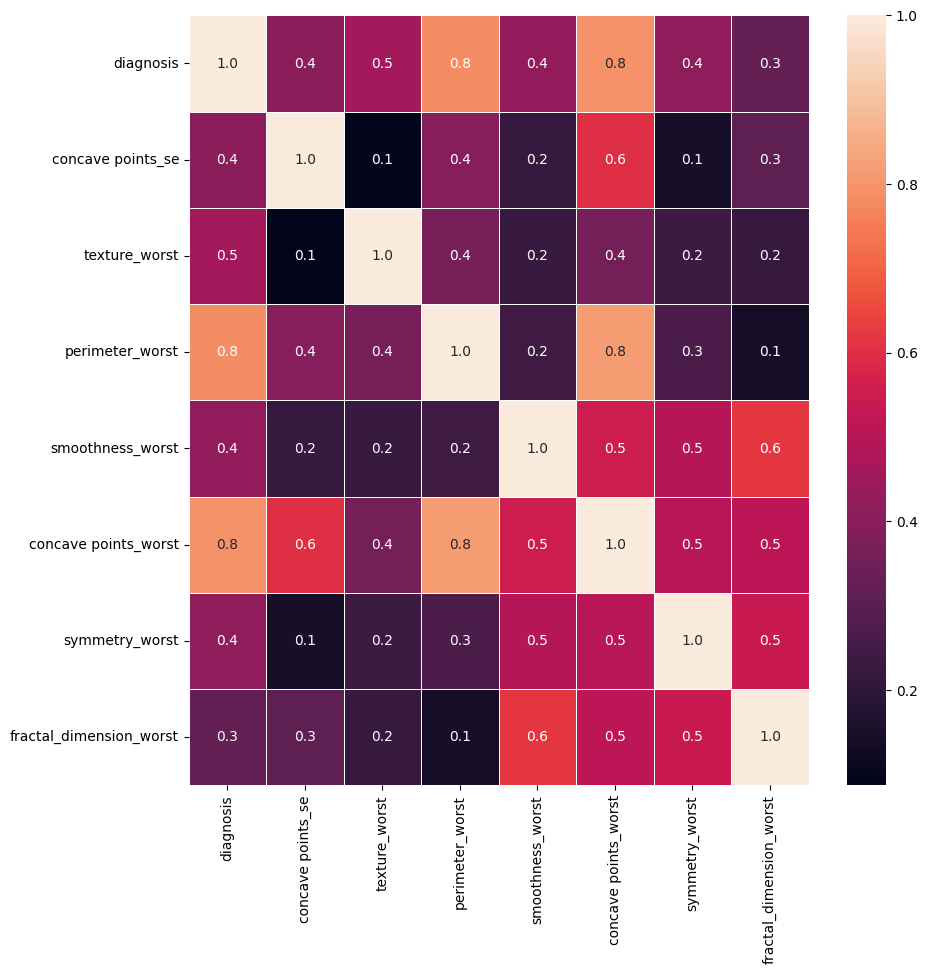

In [16]:
columns_to_remove = ['concavity_worst', 'compactness_worst', 'concave points_mean', 'concavity_mean', 'compactness_mean', 'area_worst', 'radius_worst', 'radius_mean', 'perimeter_mean', 'area_mean', 'radius_se', 'perimeter_se', 'area_se', 'texture_mean', 'smoothness_mean', 'symmetry_mean']
#'concavity_se', 'compactness_se'
df_eda.drop(columns_to_remove, axis=1, inplace=True)

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_eda.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

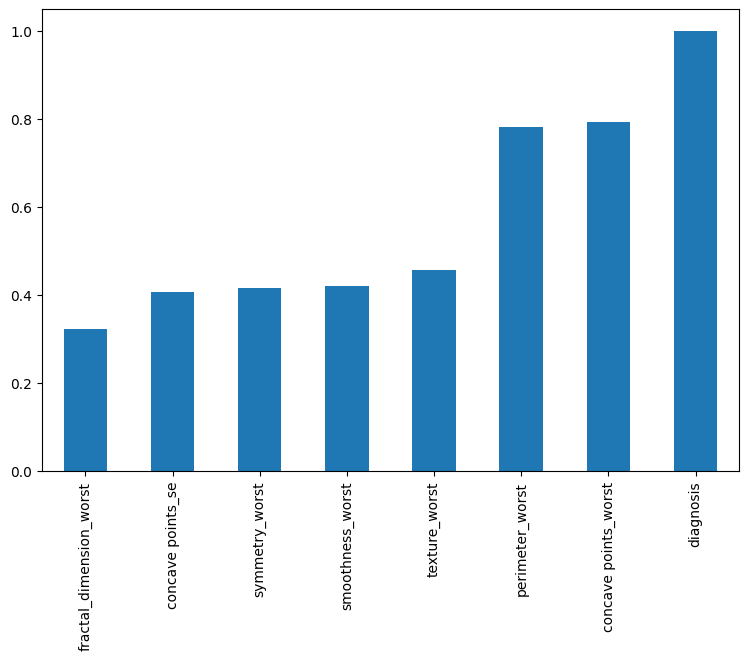

In [17]:
fig = plt.figure(figsize=(9,6))

df_eda.corr()['diagnosis'].sort_values(ascending=True).plot(kind='bar')
plt.show()

At this point, there are only the columns that seem to be relevant. I will keep both the *perimeter_worst* and *concave points_worst* columns because I think both could offer important information despite their correlation.

## Data normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_data_processing_scaled =  scaler.fit_transform(df_eda)
df_data_processing_scaled = pd.DataFrame(df_data_processing_scaled)
df_data_processing_scaled.columns = df_eda.columns
df_data_processing_scaled.head(10)

,diagnosis,concave points_se,texture_worst,perimeter_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.0,0.300625,0.141525,0.668310,0.601136,0.912027,0.598462,0.418864
1,1.0,0.253836,0.303571,0.539818,0.347553,0.639175,0.233590,0.222878
2,1.0,0.389847,0.360075,0.508442,0.483590,0.835052,0.403706,0.213433
3,1.0,0.353665,0.385928,0.241347,0.915472,0.884880,1.000000,0.773711
4,1.0,0.357075,0.123934,0.506948,0.437364,0.558419,0.157500,0.142595
5,1.0,0.215382,0.312633,0.263908,0.712739,0.598282,0.477035,0.454939
6,1.0,0.196818,0.416844,0.511928,0.482269,0.663918,0.295289,0.187853
7,1.0,0.274294,0.429638,0.299766,0.622268,0.534708,0.321506,0.393939
8,1.0,0.232241,0.498667,0.277852,0.654626,0.707904,0.554504,0.342123
9,1.0,0.271263,0.763859,0.235271,0.753682,0.759450,0.552139,1.000000


## Comparison between variables

<Figure size 1000x1000 with 0 Axes>

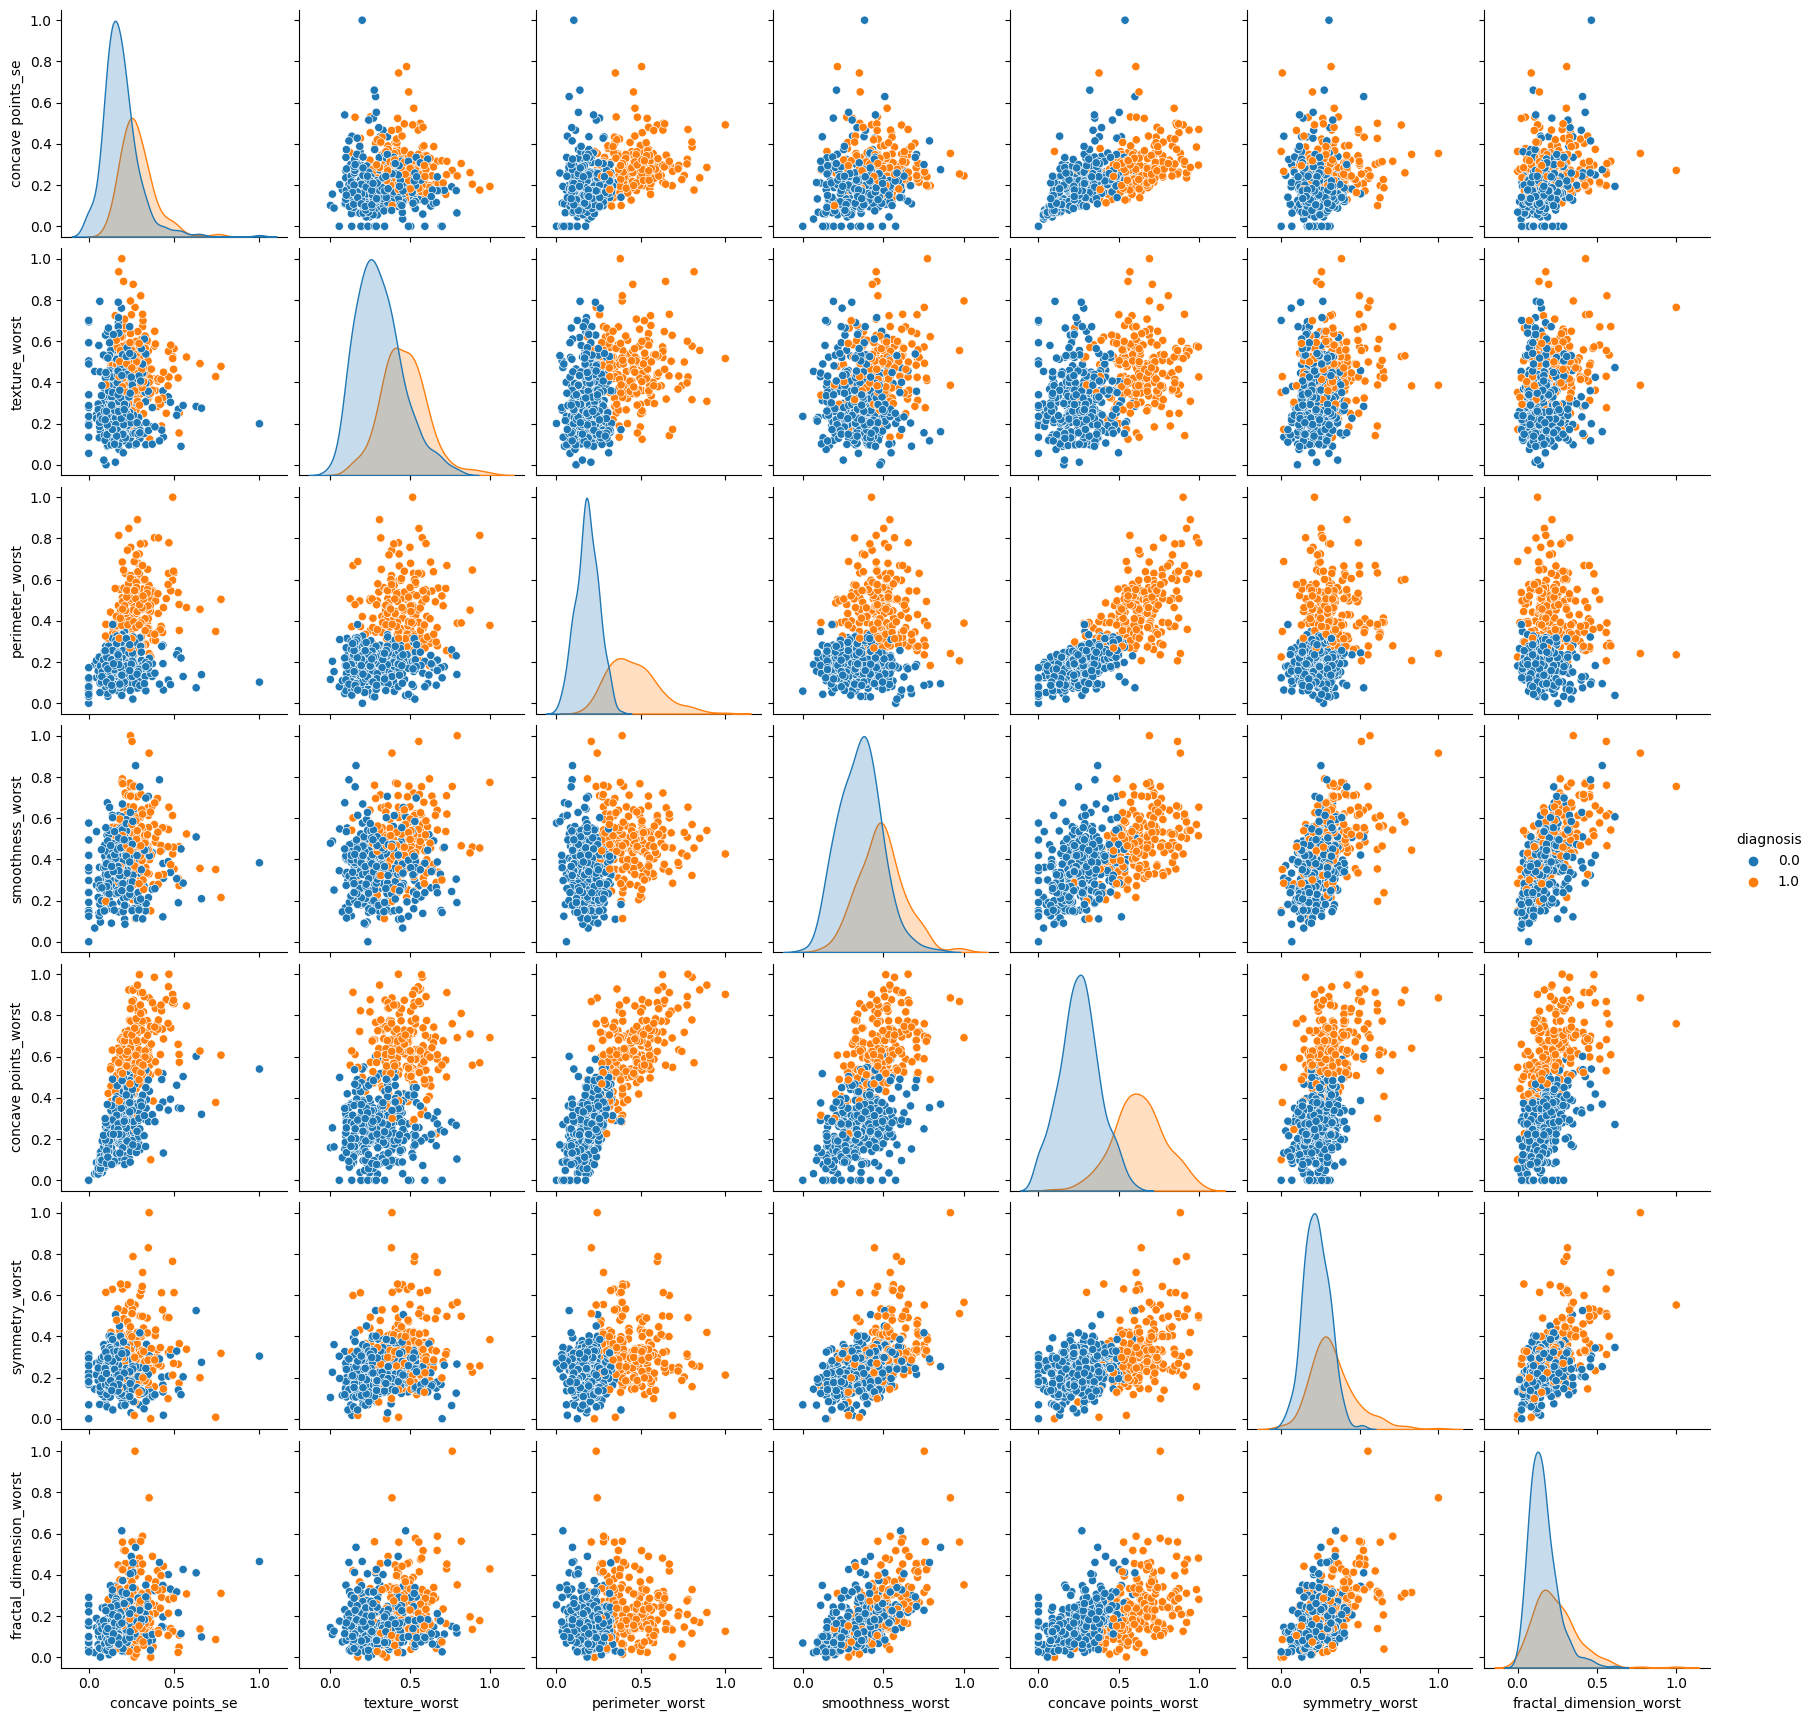

In [19]:
fig = plt.figure(figsize=(10,10))
sns.pairplot(data= df_data_processing_scaled, hue='diagnosis')
plt.show()

# Model creation

In [20]:
X = df_data_processing_scaled.drop('diagnosis',axis=1)
y = df_data_processing_scaled['diagnosis'].values

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
model = LogisticRegression()

In [22]:
result = model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

## Model evaluation

In [23]:
print(metrics.accuracy_score(y_test,prediction_test))

0.9532163742690059


In [24]:
model.feature_names_in_

array(['concave points_se', 'texture_worst', 'perimeter_worst',
       'smoothness_worst', 'concave points_worst', 'symmetry_worst',
       'fractal_dimension_worst'], dtype=object)

In [25]:
model.coef_

array([[ 1.04919466,  2.61027184,  5.0650768 ,  1.23414372,  5.04654938,
         1.48033603, -0.16443335]])

Axes(0.125,0.11;0.775x0.77)


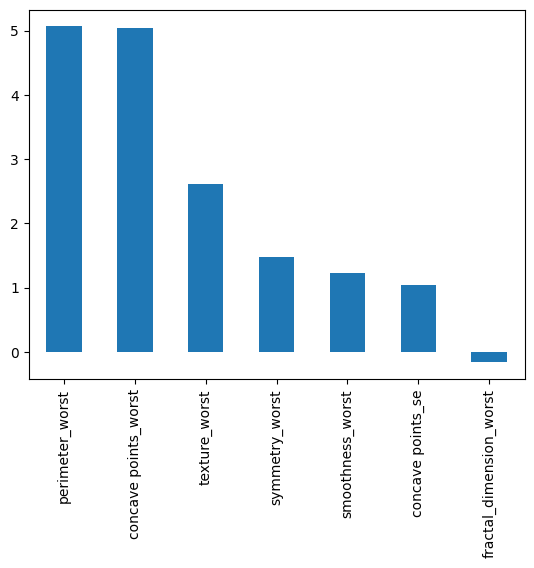

In [26]:
weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending=False)[:10].plot(kind='bar'))

<Figure size 1100x1100 with 0 Axes>

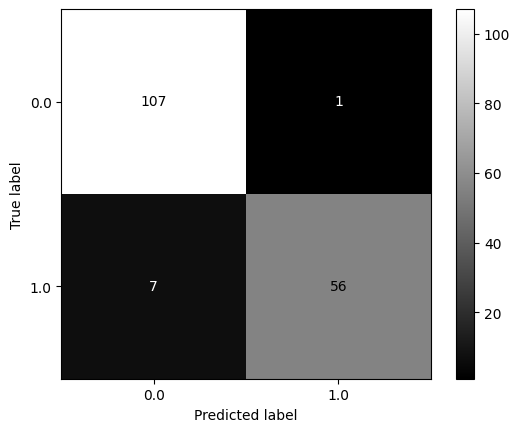

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, prediction_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
disp.plot(cmap='gray')
plt.show()

Looking at the matrix and previous metrics, we can see that our model has an accuracy of over 95% against test dataset, getting it right in almost all cases. In fact, it only gets 8 errors, where 1 of them corresponds to a bad prediction saying that it is benign and the other 7 determine that it is malignant wrongly. 

Finally, I think this is a very good starting point and I am going to perform the same test balancing the data, applying undersampling to the class that has more records. Additionaly, I'll remove the *fractal_dimension_worst* due to its almost null impact.

# Model creation with target balanced

In [28]:
from sklearn.utils import resample

def perform_undersampling(df, target_col):
    """
    Perform undersampling to balance the classes of a target variable in a dataframe.

    Parameters:
        df (pd.DataFrame): The input dataframe containing features and target variable.
        target_col (str): The name of the target variable column.

    Returns:
        pd.DataFrame: A new dataframe with balanced target classes.
    """
    
    # Separate majority and minority classes
    majority_class = df[target_col].value_counts().idxmax()
    minority_class = df[target_col].value_counts().idxmin()

    df_majority = df[df[target_col] == majority_class]
    df_minority = df[df[target_col] == minority_class]

    # Perform undersampling on the majority class
    df_majority_downsampled = resample(
        df_majority,
        replace=False,  # Do not allow replacement
        n_samples=len(df_minority),  # Match minority class size
        random_state=42  # For reproducibility
    )

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Shuffle the resulting dataframe
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

In [29]:
df_data_processing_scaled.drop('fractal_dimension_worst', axis=1, inplace=True)

df_final_balanced = perform_undersampling(df_data_processing_scaled, 'diagnosis')

X = df_final_balanced.drop('diagnosis',axis=1)
y = df_final_balanced['diagnosis'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
model = LogisticRegression()
result = model.fit(X_train, y_train)
prediction_test = model.predict(X_test)

## Evaluation

In [31]:
print(metrics.accuracy_score(y_test,prediction_test))
model.feature_names_in_

0.953125


array(['concave points_se', 'texture_worst', 'perimeter_worst',
       'smoothness_worst', 'concave points_worst', 'symmetry_worst'],
      dtype=object)

In [32]:
model.coef_

array([[1.04584224, 2.26579094, 4.2862205 , 1.31911997, 4.59438243,
        1.42830432]])

Axes(0.125,0.11;0.775x0.77)


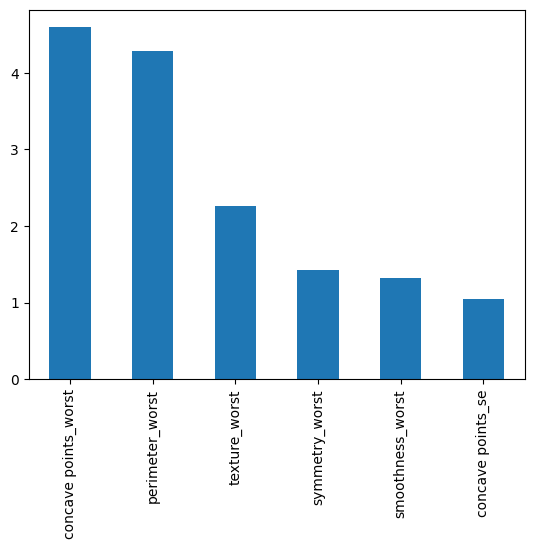

In [33]:
weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending=False)[:10].plot(kind='bar'))

<Figure size 1100x1100 with 0 Axes>

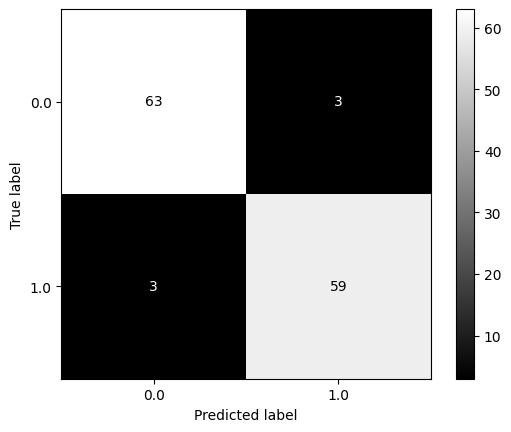

In [34]:
fig = plt.figure(figsize=(11,11))
cm = confusion_matrix(y_test, prediction_test, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=model.classes_)
disp.plot(cmap='gray')
plt.show()

By performing this test, it is observed that the precision obtained is practically the same, and now that the classes are balanced, the errors in predicting are also distributed since we have 3 in each case.